In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose


# Reading Data
[Dataset Link]("https://www.kaggle.com/atulanandjha/temperature-readings-iot-devices")

In [2]:
data = pd.read_csv('../Data/IOT-temp.csv', usecols=['noted_date', 'temp'], 
                    index_col=['noted_date'], 
                    parse_dates=True)  # Timestamp('yyyy-mm-dd hh:ii:ss')
                    
data.head()


,temp
noted_date,
2018-08-12 09:30:00,29
2018-08-12 09:30:00,29
2018-08-12 09:29:00,41
2018-08-12 09:29:00,41
2018-08-12 09:29:00,31


# Exploratory Data Analysis (EDA)

In [3]:
data.describe().T


,count,mean,std,min,25%,50%,75%,max
temp,97606.0,35.053931,5.699825,21.0,30.0,35.0,40.0,51.0


In [4]:
print(
    f"MIN datetime: {np.min(data.index)}\nMAX datetime: {np.max(data.index)}")


MIN datetime: 2018-01-11 00:06:00
MAX datetime: 2018-12-10 23:55:00


This data has very high frequency for temprature readings, We can confirm it by counting duplicated timestamps

In [5]:
print("Duplicated Timestamps Count: ", data.index.duplicated().sum())


Duplicated Timestamps Count:  69686


In [6]:
# Remove duplicated timestamps
data = data[~data.index.duplicated()]
print("Duplicated Timestamps Count: ", data.index.duplicated().sum())


Duplicated Timestamps Count:  0


Confirm that there are no any missing values

In [7]:
print("Missing Values Count: ", data.temp.isna().sum())


Missing Values Count:  0


Confirm that time series is sorted ASC correctly

In [8]:
data.sort_index(inplace=True, ascending=True)


In [9]:
import matplotlib.dates as mdates

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y-%m')


<AxesSubplot:title={'center':'Time Series'}, xlabel='Month', ylabel='Temprature'>

<Figure size 1728x432 with 0 Axes>

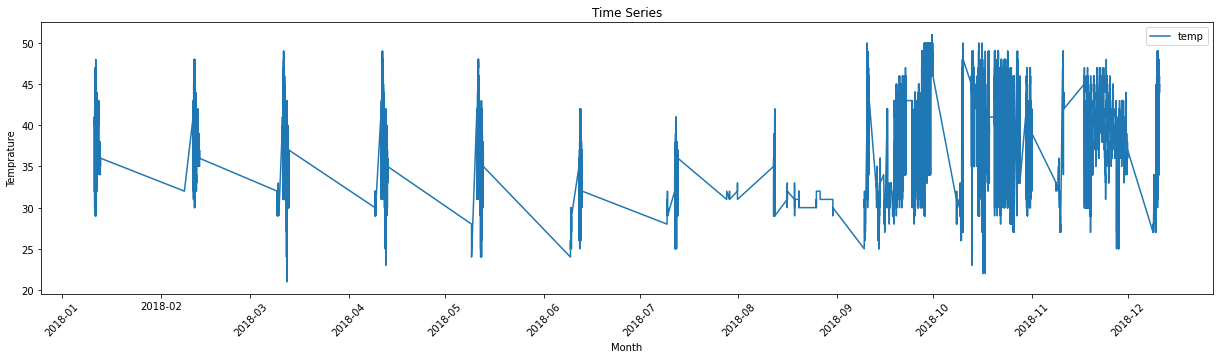

In [10]:
plt.figure(figsize=(24, 6))
fig, ax = plt.subplots(figsize=(21, 5))
ax.set_title('Time Series')
ax.set_xlabel('Month')
ax.set_ylabel('Temprature')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)
plt.xticks(rotation=45)
sns.lineplot(data=data)


We found that all records in `2018`, but now we need to check density of readings for each month

Text(0, 0.5, 'Count')

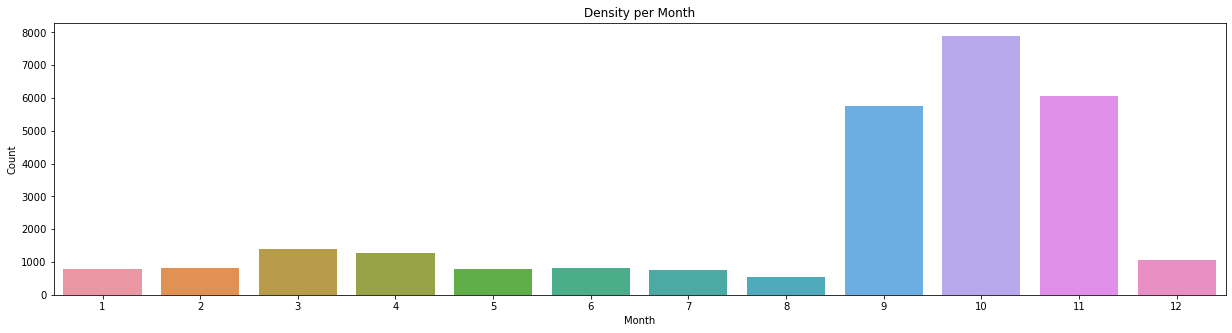

In [11]:
month_freq = data.groupby(by=[data.index.month]).count().T

# Barplot Figure
fig, ax = plt.subplots(figsize=(21, 5))
sns.barplot(data=month_freq, ax=ax)
ax.set_title('Density per Month')
ax.set_xlabel('Month')
ax.set_ylabel('Count')


Now, We need to decompose this time series into its initial components:
- Seasons
- Trend
- Noise

Text(0.5, 0.98, 'Seasonal Decomposition')

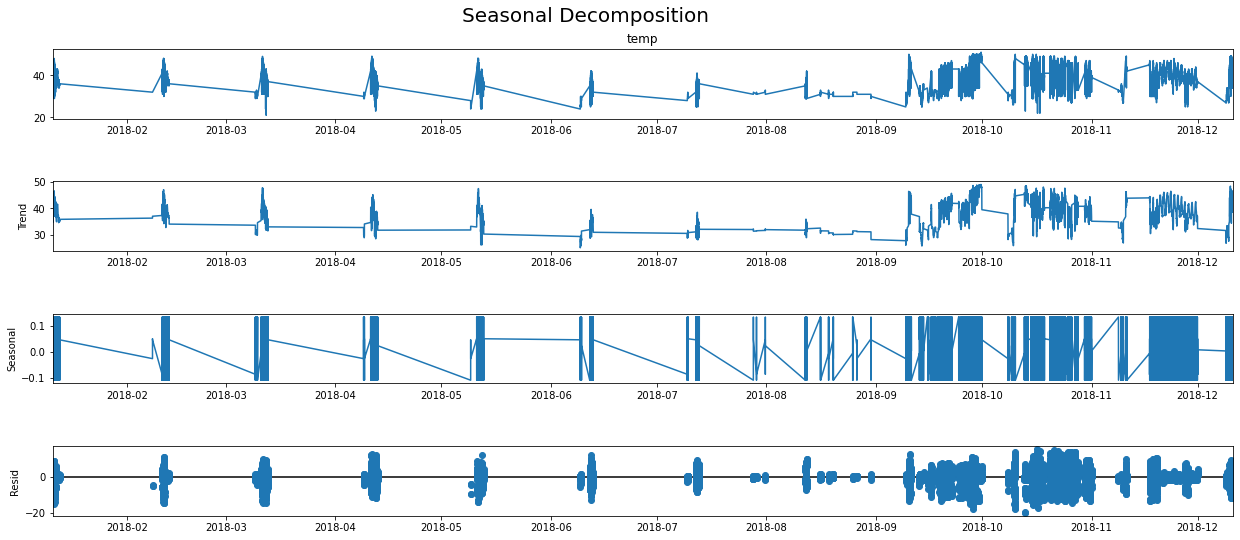

In [12]:
result = seasonal_decompose(data['temp'], model='Additive', period=12)
season_fig = result.plot()
season_fig.set_size_inches((20, 8))
season_fig.suptitle("Seasonal Decomposition", fontsize=20)


# Auto Regressive Integrated Moving Average (ARIMA) Forecasting

Any `Non-Seasonal` time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models. An ARIMA model is characterized by 3 terms (p, d, q), where:
- `p` is the order of the AR term
- `q` is the order of the MA term
- `d` is the number of differencing required to make the time series stationary

Predicted: 
> Y_t = Constant + Linear Combination Lags of Y (upto p lags) + Linear Combination of Lagged forecast errors (upto q lags)

Check if the series is stationary using `Augmented Dickey Fuller` test, to determine the right value of `d` to make the time series `Stationary`

<br>

The `null hypothesis` of the `ADF` test is that the time series is `non-stationary`. So, if the `p-value` of the test is less than the significance level `(0.05)` then you `reject` the `null hypothesis` and infer that the time series is indeed `stationary`.

In [13]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['temp'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -7.585972
p-value: 0.000000


We can confirm if `Stationarity` exists or not using `Auto Correlation Function (ACF)`

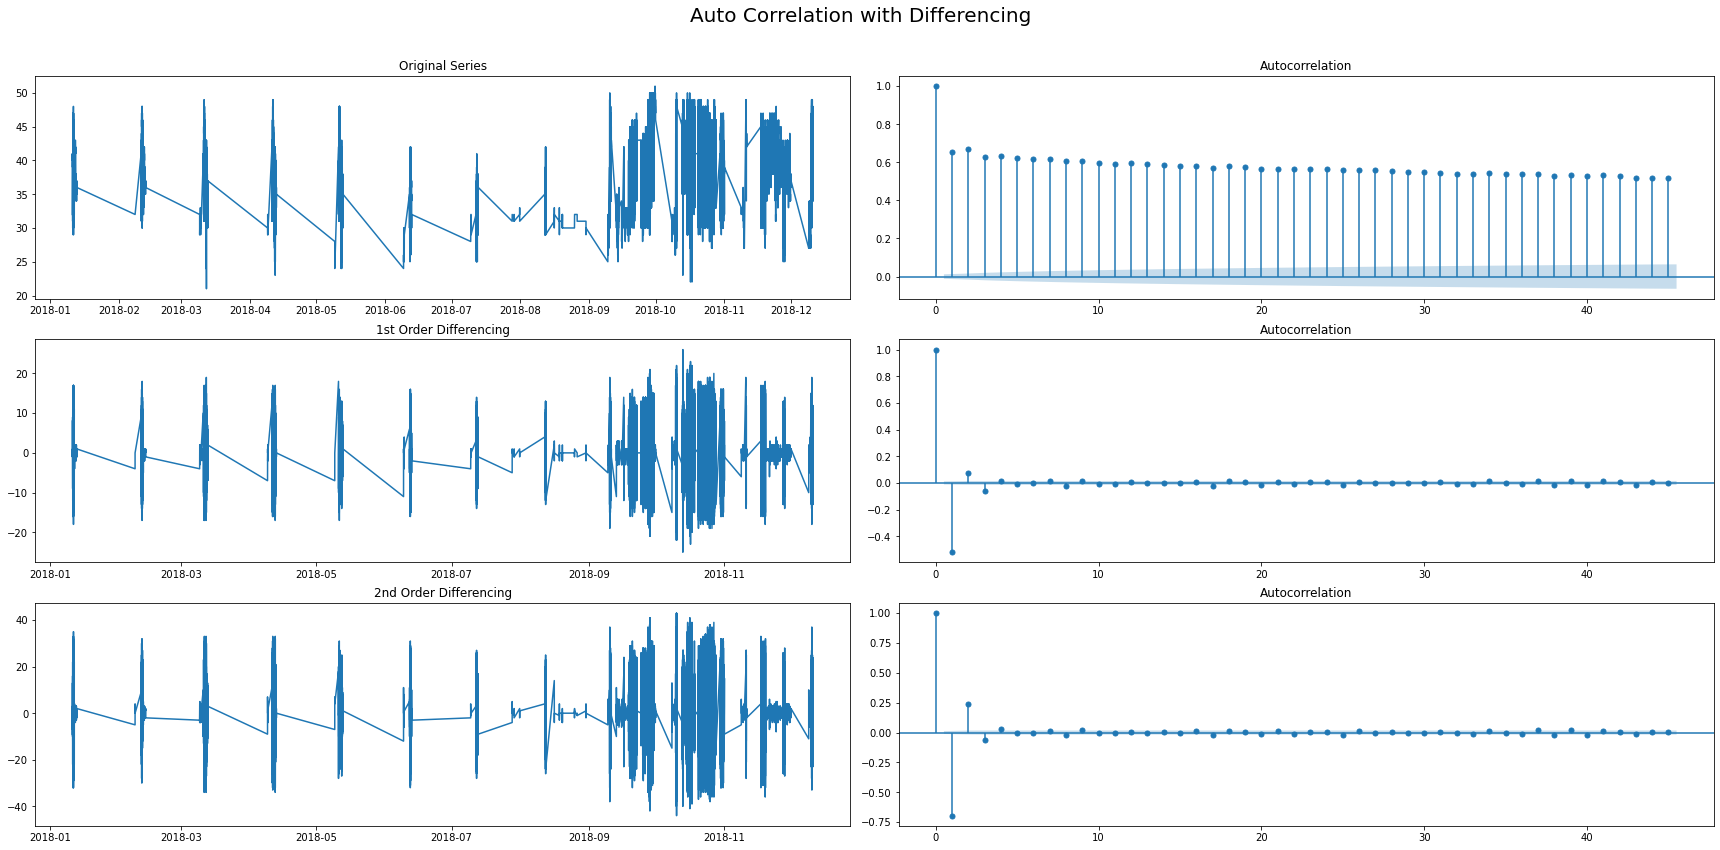

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(24, 12)})

fig, axes = plt.subplots(3, 2)
# Original
axes[0, 0].plot(data['temp'])
axes[0, 0].set_title('Original Series')
axes[0, 0].xaxis.set_major_locator(months)
axes[0, 0].xaxis.set_major_formatter(years_fmt)
axes[0, 0].xaxis.set_minor_locator(months)
plot_acf(data.temp, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(data.temp.diff())
axes[1, 0].set_title('1st Order Differencing')
plot_acf(data.temp.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(data.temp.diff().diff())
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(data.temp.diff().diff().dropna(), ax=axes[2, 1])

fig.tight_layout()
fig.suptitle('Auto Correlation with Differencing', fontsize=20)
fig.subplots_adjust(top=0.90)
plt.show()

To determine `p` and `q` We need to use `Partial Auto Correlation Function (PACF)`

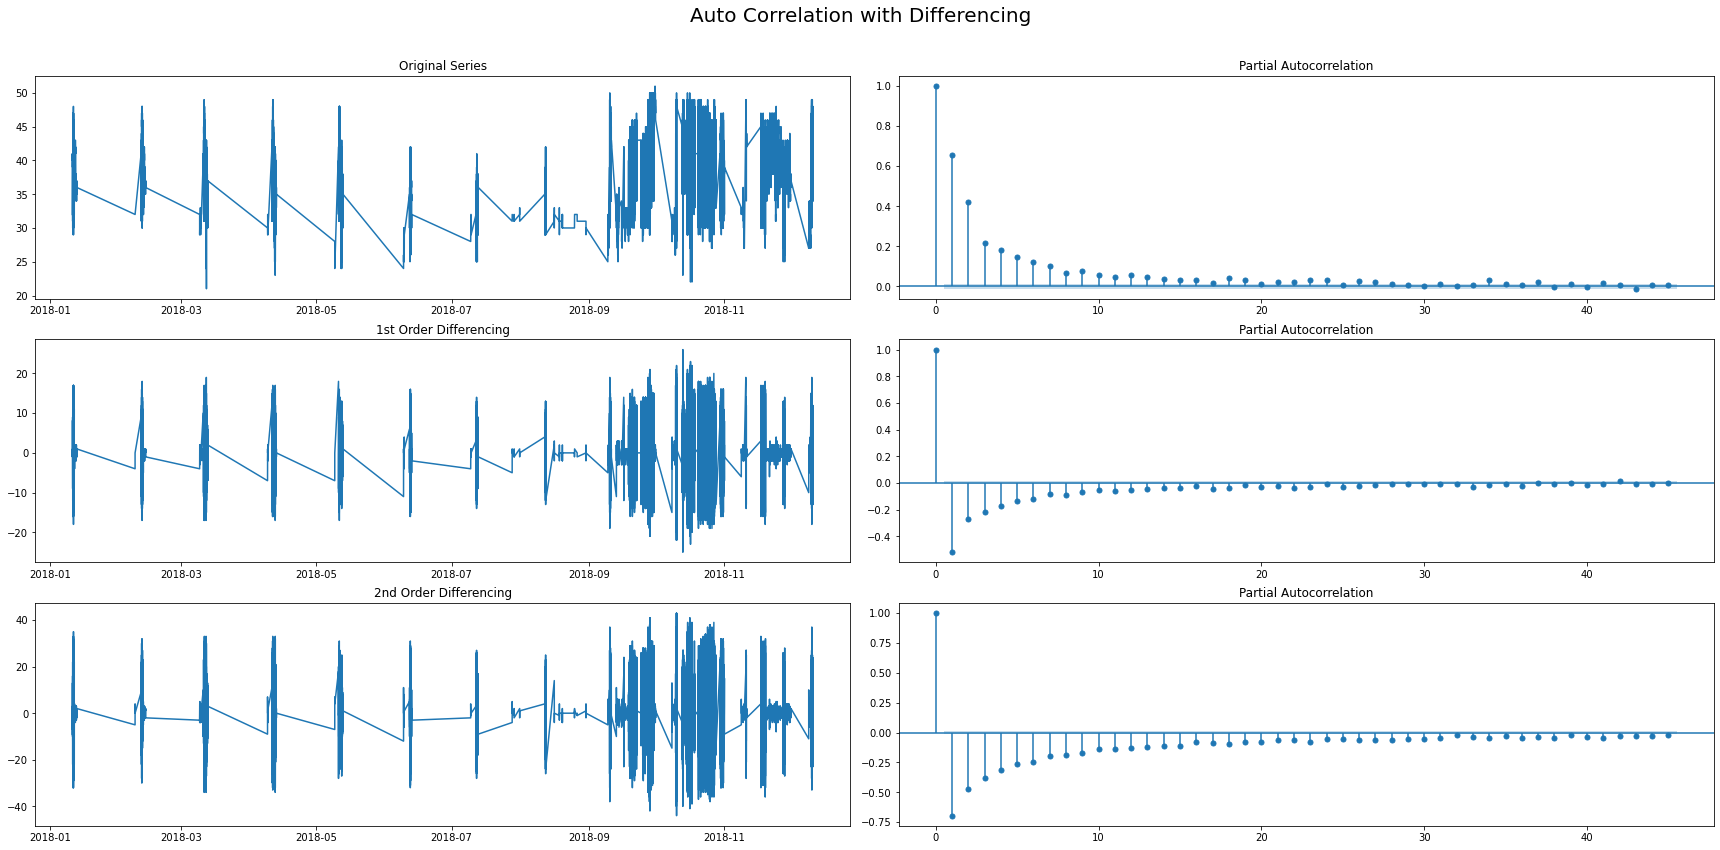

In [15]:
plt.rcParams.update({'figure.figsize':(24, 12)})

fig, axes = plt.subplots(3, 2)
# Original
axes[0, 0].plot(data['temp'])
axes[0, 0].set_title('Original Series')
plot_pacf(data.temp, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(data.temp.diff())
axes[1, 0].set_title('1st Order Differencing')
plot_pacf(data.temp.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(data.temp.diff().diff())
axes[2, 0].set_title('2nd Order Differencing')
plot_pacf(data.temp.diff().diff().dropna(), ax=axes[2, 1])

fig.tight_layout()
fig.suptitle('Auto Correlation with Differencing', fontsize=20)
fig.subplots_adjust(top=0.90)
plt.show()

> It may so happen that your series is slightly under differenced, that differencing it one more time makes it slightly over-differenced.

> **How to handle this case?**

> If your series is slightly under differenced, adding one or more additional AR terms usually makes it up. Likewise, if it is slightly over-differenced, try adding an additional MA term.

Now, It's time to build our `ARIMA` model

In [23]:
# split data into train, test
msk = int(len(data) * 0.85) + 679

train_set = data[:msk]
test_set = data[msk:]

train_set.index = pd.DatetimeIndex(train_set.index).to_period('D')
test_set.index = pd.DatetimeIndex(test_set.index).to_period('D')

print(f"Training Set Size: {len(train_set)} | Testing Set Size: {len(test_set)}")
train_set.index[-1], test_set.index[0]

Training Set Size: 24411 | Testing Set Size: 3509


(Period('2018-11-23', 'D'), Period('2018-11-24', 'D'))

In [24]:
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA', FutureWarning)

# ARIMA Model
model = ARIMA(endog=train_set, order=(2, 0, 2))
model_fit = model.fit()
print(model_fit.summary())


C:\Users\moham\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                              ARMA Model Results                              
Dep. Variable:                   temp   No. Observations:                24411
Model:                     ARMA(2, 2)   Log Likelihood              -69413.111
Method:                       css-mle   S.D. of innovations              4.156
Date:                Wed, 15 Dec 2021   AIC                         138838.221
Time:                        19:32:16   BIC                         138886.838
Sample:                    01-11-2018   HQIC                        138853.975
                         - 11-23-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         37.5721      0.528     71.197      0.000      36.538      38.606
ar.L1.temp     0.2308      0.057      4.053      0.000       0.119       0.342
ar.L2.temp     0.7558      0.057     13.355      0.0

In [40]:
# Forecast
fc = model_fit.predict(start=test_set.index[0], end=test_set.index[-1])
# Make as pandas series
fc_series = pd.Series(fc, index=test_set.index)

In [41]:
from sklearn.metrics import mean_squared_error

print("MSE Loss: ", mean_squared_error(test_set, fc_series))

MSE Loss:  47.18667020962694


# Auto ARIMA

In [42]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(train_set.temp, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=2, max_q=2, # maximum p and q
                      d=None,           # let model determine 'd'
                      seasonal=True,    # Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      n_fits=5,
                      n_jobs=2)

print(model.summary())

C:\Users\moham\anaconda3\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=138857.482, Time=45.86 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=159877.023, Time=1.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=147105.428, Time=2.34 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=153327.703, Time=7.45 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=247005.798, Time=0.56 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=138848.682, Time=52.70 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=142531.945, Time=4.11 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=138839.044, Time=70.57 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=138850.716, Time=67.09 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=138925.415, Time=25.32 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] intercept
Total fit time: 277.472 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                24411
Model:               SARIMAX(2, 0, 